<a href="https://colab.research.google.com/github/kennethgoodman/Columbia-E4579/blob/main/image_generation_pipelines/dalle_mini_Inference_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DALL·E mini - Inference pipeline

*Generate images from a text prompt*

<img src="https://github.com/borisdayma/dalle-mini/blob/main/img/logo.png?raw=true" width="200">

This notebook illustrates [DALL·E mini](https://github.com/borisdayma/dalle-mini) inference pipeline.

Just want to play? Use directly [the app](https://www.craiyon.com/).

For more understanding of the model, refer to [the report](https://wandb.ai/dalle-mini/dalle-mini/reports/DALL-E-mini--Vmlldzo4NjIxODA).

Forked from https://colab.research.google.com/github/borisdayma/dalle-mini/blob/main/tools/inference/inference_pipeline.ipynb#scrollTo=SDjEx9JxR3v8

## 🛠️ Installation and set-up

In [61]:
# Install required libraries
!pip install -q dalle-mini
!pip install -q git+https://github.com/patil-suraj/vqgan-jax.git

     |████████████████████████████████| 235 kB 12.9 MB/s 
     |████████████████████████████████| 4.7 MB 72.8 MB/s 
     |████████████████████████████████| 197 kB 86.9 MB/s 
     |████████████████████████████████| 180 kB 65.8 MB/s 
     |████████████████████████████████| 53 kB 2.1 MB/s 
     |████████████████████████████████| 1.8 MB 62.1 MB/s 
     |████████████████████████████████| 1.0 MB 84.1 MB/s 
     |████████████████████████████████| 145 kB 76.1 MB/s 
     |████████████████████████████████| 596 kB 93.9 MB/s 
     |████████████████████████████████| 217 kB 77.8 MB/s 
     |████████████████████████████████| 51 kB 5.6 MB/s 
     |████████████████████████████████| 76 kB 5.2 MB/s 
     |████████████████████████████████| 6.6 MB 59.4 MB/s 
     |████████████████████████████████| 101 kB 13.2 MB/s 
     |████████████████████████████████| 157 kB 95.2 MB/s 
     |████████████████████████████████| 181 kB 92.9 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
     |████████████████

We load required models:
* DALL·E mini for text to encoded images
* VQGAN for decoding images
* CLIP for scoring predictions

In [62]:
# Model references

# dalle-mega
DALLE_MODEL = "dalle-mini/dalle-mini/mega-1-fp16:latest"  # can be wandb artifact or 🤗 Hub or local folder or google bucket
DALLE_COMMIT_ID = None

# if the notebook crashes too often you can use dalle-mini instead by uncommenting below line
# DALLE_MODEL = "dalle-mini/dalle-mini/mini-1:v0"

# VQGAN model
VQGAN_REPO = "dalle-mini/vqgan_imagenet_f16_16384"
VQGAN_COMMIT_ID = "e93a26e7707683d349bf5d5c41c5b0ef69b677a9"

In [63]:
import jax
import jax.numpy as jnp

# check how many devices are available
jax.local_device_count()

1

In [64]:
# Load models & tokenizer
from dalle_mini import DalleBart, DalleBartProcessor
from vqgan_jax.modeling_flax_vqgan import VQModel
from transformers import CLIPProcessor, FlaxCLIPModel

# Load dalle-mini
model, params = DalleBart.from_pretrained(
    DALLE_MODEL, revision=DALLE_COMMIT_ID, dtype=jnp.float16, _do_init=False
)

# Load VQGAN
vqgan, vqgan_params = VQModel.from_pretrained(
    VQGAN_REPO, revision=VQGAN_COMMIT_ID, _do_init=False
)

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Downloading large artifact mega-1-fp16:latest, 4938.53MB. 7 files... Done. 0:0:42.6
Some of the weights of DalleBart were initialized in float16 precision from the model checkpoint at /tmp/tmp9dhf6avn:
[('lm_head', 'kernel'), ('model', 'decoder', 'embed_positions', 'embedding'), ('model', 'decoder', 'embed_tokens', 'embedding'), ('model', 'decoder', 'final_ln', 'bias'), ('model', 'decoder', 'layernorm_embedding', 'bias'), ('model', 'decoder', 'layernorm_embedding', 'scale'), ('model', 'decoder', 'layers', 'FlaxBartDecoderLayers', 'FlaxBartAttention_0', 'k_proj', 'kernel'), ('model', 'decoder', 'layers', 'FlaxBartDecoderLayers', 'FlaxBartAttention_0', 'out_proj', 'kernel'), ('model', 'decoder', 'layers', 'FlaxBartDecoderLayers', 'FlaxBartAttention_0', 'q_proj', 'kernel'), ('model', 'decoder', 'layers', 'FlaxBartDecoderLayers', 'FlaxBartAttention_0', 'v_proj', 'kernel'), ('model', 'decoder', 'layers', 'FlaxBart

Model parameters are replicated on each device for faster inference.

In [65]:
from flax.jax_utils import replicate

params = replicate(params)
vqgan_params = replicate(vqgan_params)

Model functions are compiled and parallelized to take advantage of multiple devices.

In [66]:
from functools import partial

# model inference
@partial(jax.pmap, axis_name="batch", static_broadcasted_argnums=(3, 4, 5, 6))
def p_generate(
    tokenized_prompt, key, params, top_k, top_p, temperature, condition_scale
):
    return model.generate(
        **tokenized_prompt,
        prng_key=key,
        params=params,
        top_k=top_k,
        top_p=top_p,
        temperature=temperature,
        condition_scale=condition_scale,
    )


# decode image
@partial(jax.pmap, axis_name="batch")
def p_decode(indices, params):
    return vqgan.decode_code(indices, params=params)

Keys are passed to the model on each device to generate unique inference per device.

In [67]:
import random

# create a random key
seed = random.randint(0, 2**32 - 1)
key = jax.random.PRNGKey(seed)

## 🖍 Text Prompt

Our model requires processing prompts.

In [68]:
from dalle_mini import DalleBartProcessor

processor = DalleBartProcessor.from_pretrained(DALLE_MODEL, revision=DALLE_COMMIT_ID)

wandb: Downloading large artifact mega-1-fp16:latest, 4938.53MB. 7 files... Done. 0:0:36.1


Downloading:   0%|          | 0.00/34.2M [00:00<?, ?B/s]

## 🎨 Generate images

We generate images using dalle-mini model and decode them with the VQGAN.

In [69]:
# number of predictions per prompt
n_predictions = 6

# We can customize generation parameters (see https://huggingface.co/blog/how-to-generate)
gen_top_k = None
gen_top_p = None
temperature = None
cond_scale = 10.0

In [70]:
# CLIP model
CLIP_REPO = "openai/clip-vit-base-patch32"
CLIP_COMMIT_ID = None

# Load CLIP
clip, clip_params = FlaxCLIPModel.from_pretrained(
    CLIP_REPO, revision=CLIP_COMMIT_ID, dtype=jnp.float16, _do_init=False
)
clip_processor = CLIPProcessor.from_pretrained(CLIP_REPO, revision=CLIP_COMMIT_ID)
clip_params = replicate(clip_params)

# score images
@partial(jax.pmap, axis_name="batch")
def p_clip(inputs, params):
    logits = clip(params=params, **inputs).logits_per_image
    return logits

In [77]:
#@markdown Enable saving outputs to Google Drive to save your creations at AI/models
save_outputs_to_google_drive = True #@param {type:"boolean"}

if save_outputs_to_google_drive:
    from google.colab import drive
    try:
      drive.mount('/content/gdrive')
    except:
      save_outputs_to_google_drive = False

outputs_path = "/content/gdrive/MyDrive/AI/DalleMini/samples" if save_outputs_to_google_drive else "/content/outputs"
!mkdir -p $outputs_path
print(f"Outputs will be saved to {outputs_path}")
import os
os.makedirs(outputs_path, exist_ok=True)


Mounted at /content/gdrive
Outputs will be saved to /content/gdrive/MyDrive/AI/DalleMini/samples


In [72]:
from flax.training.common_utils import shard_prng_key
import numpy as np
from PIL import Image
from tqdm.notebook import trange
from flax.training.common_utils import shard

def get_encode_images(tokenized_prompt, subkey):
  return p_generate(
      tokenized_prompt,
      shard_prng_key(subkey),
      params,
      gen_top_k,
      gen_top_p,
      temperature,
      cond_scale,
  )

def remove_bos(encoded_images):
  return encoded_images.sequences[..., 1:]

def decode_images(encoded_images):
  images = []
  decoded_images = p_decode(encoded_images, vqgan_params)
  decoded_images = decoded_images.clip(0.0, 1.0).reshape((-1, 256, 256, 3))
  for decoded_img in decoded_images:
      img = Image.fromarray(np.asarray(decoded_img * 255, dtype=np.uint8))
      images.append(img)
  return images

def save_images(images, prompt):
  for img in images:
    base_count = len(os.listdir(outputs_path))
    os.path.join(outputs_path, f'{prompt.replace(" ", "-")}.{base_count}.png')

def saving_images_with_scores(images_with_scores, prompt, top_k=2):
  for i, (img, score) in enumerate(images_with_scores[:top_k]):
    base_count = len(os.listdir(outputs_path))
    os.path.join(outputs_path, f'{prompt.replace(" ", "-")}.{i}.{score}.png')

def display_images(images):
  for img in images:
    display(img)
    print()

def display_images_with_scores(images_with_scores):
  for (img, score) in images_with_scores:
    display(img)
    print(f"Score: {score:.2f}\n")

def get_tokenized_prompt(prompt):
  tokenized_prompt = processor(prompt)
  return replicate(tokenized_prompt)

def get_images(key, prompts):
  images = []
  tokenized_prompt = get_tokenized_prompt(prompts)
  for i in trange(max(n_predictions // jax.device_count(), 1)):
      # get a new key
      key, subkey = jax.random.split(key)
      # generate images and remove BOS
      encoded_images = remove_bos(get_encode_images(tokenized_prompt, subkey))
      # decode images
      images.extend(decode_images(encoded_images))
  return images


def get_logits(images):
  # get clip scores
  clip_inputs = clip_processor(
      text=prompts * jax.device_count(),
      images=images,
      return_tensors="np",
      padding="max_length",
      max_length=77,
      truncation=True,
  ).data
  logits = p_clip(shard(clip_inputs), clip_params)
  return logits      


def rank_images(images, prompts):
  logits = get_logits(images)
  prompts_to_images_with_score = {}
  p = len(prompts)
  logits = np.asarray([logits[:, i::p, i] for i in range(p)]).squeeze()
  for i, prompt in enumerate(prompts):
      prompts_to_images_with_score[prompt] = []
      to_argsort = logits[i] if p > 1 else logits
      for idx in to_argsort.argsort()[::-1]:
          new_image = images[idx * p + i]
          score = jnp.asarray(to_argsort[idx], dtype=jnp.float32)
          prompts_to_images_with_score[prompt].append((new_image, score))
  return prompts_to_images_with_score



We will generate promps from Reddit titles

In [56]:
import requests
import time

def should_filter_in(title):
  return 'NSFW' not in title and len(title) > 50

def edit_title(title):
  return title.replace('(OC)', '').replace('[OC]', '').replace('i made a', '')

def get_titles(data):
  titles = [child['data']['title'].lower() for child in data]
  filtered_titles = filter(should_filter_in, titles)
  mapped_titles = map(edit_title, filtered_titles)
  return set(mapped_titles)


headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}

def get_top_titles_from_subreddit(subreddit, total_limit=1000, t='all'):
  after = ''
  r = requests.get(f'https://www.reddit.com/r/{subreddit}/top.json?limit=100&t={t}', headers=headers)
  x = r.json()
  titles = get_titles(x['data']['children'])
  while len(titles) < total_limit and x['data']['after'] is not None:
    r = requests.get(f"https://www.reddit.com/r/{subreddit}/top.json?limit=100&after={x['data']['after']}&t={t}", headers=headers)
    x = r.json()
    titles |= get_titles(x['data']['children'])
    time.sleep(2)
  return titles

subreddits = ['pics', 'MadeMeSmile', 'Damnthatsinteresting', 'worldnews', 'Confessions', 'AccidentalArt', 'scifi', 'SimplePrompts']
titles = set()
for subreddit in subreddits:
  titles |= get_top_titles_from_subreddit(subreddit)

In [73]:
import random
random.sample(list(titles), 5)

['happy 11 year anniversary jamal',
 'a local fisherman in costa rica nursed a crocodile back to health after it had been shot in the head, and released the reptile back to its home. the next day, the man discovered “pocho” had followed him home and was sleeping on the man’s porch. for 20 years pocho became part of the man’s family.',
 'hocked a luggi, made a flaming match stick.',
 'protests erupt in jerusalem over murder of eyad halaq, an unarmed autistic palestinian, by israeli forces',
 "sofia posmysz's mugshot after being arrested for distributing anti-nazi leaflets. she was sent to auschwitz but survived 2 concentration camps and today is 98 ."]

In [83]:
prompts = ["""A man was sat alone in a car. The time of night was just about perfect as far as he was concerned. Its dark the moon is hidden behind the clouds and a distinct lack of people. All good if you’re hoping to go about your business without being disturbed. He has been observing this property for the last couple of weeks, home to a small family, no pets and nothing valuable enough to require an alarm.

The back door yields with ease to his expert skills and he's in so quick he may have gone unnoticed in broad daylight. He looks around the room taking a mental inventory of what he wants and what he’ll leave. There are a few electronics and a few Blu-Rays for his ‘personal’ collection. The shelves hold very little of value mainly knick-knacks and photos but some small change is quickly pocketed.

Something didn’t feel right, he stood as still as possible and listened, scanning the room, and positive he heard someone moving. After a few moments he relaxed slightly, the only thing moving were the arms of the clock it would seem, still, paranoia has been proven to be a useful tool in his trade; the feeling someone is watching forced him to take greater care.

He continued to look around downstairs bagging him a couple of leather jackets, a few pieces of silver and one designer handbag complete with a purse containing cards and money. He could possibly have stopped there, he’s got enough stuff to see him through the next week or two, but greed is in his ear. Taking his current haul he placed it outside, after-all he didn’t want to be walking around the house with bags of stuff that would be far too noisy and he wasn’t Santa."""]

In [ ]:
from collections import Counter
Counter(map(len, titles))

  0%|          | 0/6 [00:00<?, ?it/s]

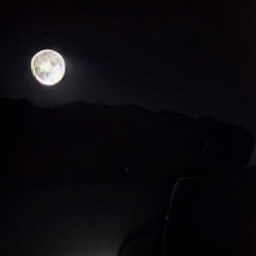

Score: 28.32



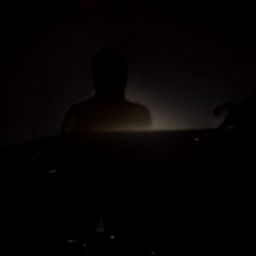

Score: 28.30



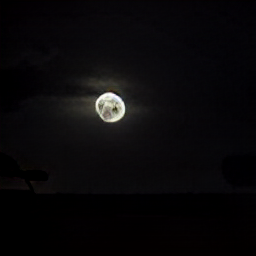

Score: 27.59



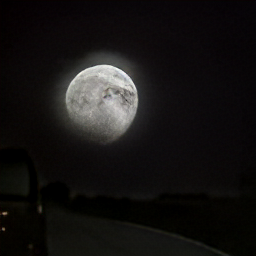

Score: 25.76



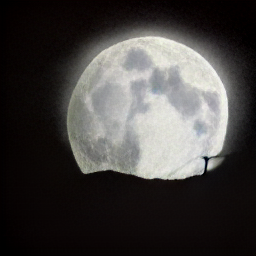

Score: 25.56



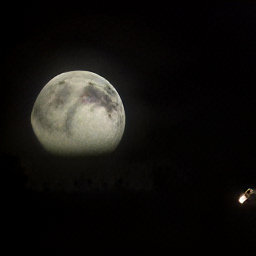

Score: 23.49



In [84]:
# prompts = random.sample(list(titles), 10)

# print(f"Prompts: {prompts}\n")
# generate images
seed = random.randint(0, 2**32 - 1)
key = jax.random.PRNGKey(seed)
images = get_images(key, prompts)
ranked_images = rank_images(images, prompts)
for prompt in prompts:
  # print(f"Doing: {prompt}")
  display_images_with_scores(ranked_images[prompt])
  # saving_images_with_scores(ranked_images[prompt], prompt)

## 🪄 Optional: Save your Generated Images as W&B Tables

W&B Tables is an interactive 2D grid with support to rich media logging. Use this to save the generated images on W&B dashboard and share with the world.

In [76]:
import wandb

# Initialize a W&B run.
project = 'dalle-mini-tables-colab'
run = wandb.init(project=project)

# Initialize an empty W&B Tables.
columns = ["captions"] + [f"image_{i+1}" for i in range(n_predictions)]
gen_table = wandb.Table(columns=columns)

# Add data to the table.
for i, prompt in enumerate(prompts):
    # If CLIP scores exist, sort the Images
    tmp_ranked_images = ranked_images[prompt]
    
    # Add the data to the table.
    gen_table.add_data(prompt, *[wandb.Image(img) for (img, _) in tmp_ranked_images])

# Log the Table to W&B dashboard.
wandb.log({"Generated Images": gen_table})

# Close the W&B run.
run.finish()

wandb: Currently logged in as: kgoodman. Use `wandb login --relogin` to force relogin


Click on the link above to check out your generated images.